## 🌐 **Google Drive and Kaggle Connection**

In [1]:
# Install and configure Kaggle API
!pip install -q kaggle

import os
from google.colab import drive
from google.colab import files

# --- Configuration ---
# Percorso di destinazione sul Drive
DRIVE_MOUNT_PATH = "/content/gdrive"
DATASET_PATH = f"{DRIVE_MOUNT_PATH}/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset"
COMPETITION_ID = "an2dl2526c2v2"
ZIP_FILENAME = f"{COMPETITION_ID}.zip"
EXPECTED_ZIP_FILE = os.path.join(DATASET_PATH, ZIP_FILENAME)

# --- 1. Mount Google Drive ---
print("1. Mounting Google Drive...")
# Mount G-Drive if it's not already mounted
if not os.path.exists(DRIVE_MOUNT_PATH):
    drive.mount(DRIVE_MOUNT_PATH)
else:
    print("Drive already mounted.")

# --- 2. Check for Existing Data ---
if os.path.exists(EXPECTED_ZIP_FILE):
    print(f"\n✅ Dataset found at {DATASET_PATH}. Skipping download and setup.")
    # You can also add a check here for the unzipped folders if you prefer.
else:
    # --- 3. Setup Kaggle Credentials (Only if download is needed) ---
    print("\n⏳ Dataset not found. Starting Kaggle setup and download.")

    # 3a. Upload kaggle.json
    print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")

    # Check if files.upload() returned a file (if running interactively)
    # The uploaded dictionary keys are the filenames.
    uploaded = files.upload()

    if "kaggle.json" in uploaded:
        # 3b. Configura le credenziali
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle credentials configured.")

        # 3c. Create destination folder and Download
        !mkdir -p {DATASET_PATH}
        print(f"Downloading dataset to: {DATASET_PATH}")
        # Scarica il dataset direttamente da Kaggle nella cartella scelta
        !kaggle competitions download -c {COMPETITION_ID} -p {DATASET_PATH}

    else:
        print("\n⚠️ kaggle.json not uploaded. Cannot proceed with download.")


# --- 4. Decompress Data (Always check for existence before unzipping) ---

EXPECTED_UNZIPPED_FILE = os.path.join(DATASET_PATH, "train_labels.csv")

if os.path.exists(EXPECTED_UNZIPPED_FILE):
    # Check if the key unzipped file is already there
    print(f"\n📦 Data appears to be already unzipped (found: {os.path.basename(EXPECTED_UNZIPPED_FILE)}). Skipping decompression.")

elif os.path.exists(EXPECTED_ZIP_FILE):
    # Only unzip if the zip file is present AND the unzipped files are missing
    print("\n📦 Competition zip found but data not yet extracted. Starting decompression...")

    # -o flag is usually kept for safety, but if you want STRICTLY NO overwrite, you can remove it.
    # For speed optimization, we rely on the outer 'if' block to skip the entire step.
    !unzip -o {EXPECTED_ZIP_FILE} -d {DATASET_PATH}

else:
    # This scenario means neither the zip nor the unzipped files were found.
    # This should only happen if the preceding download step failed or was skipped.
    print("\n⚠️ Cannot decompress: Competition zip file is missing.")

print(f"\nFinal status: Dataset available in: {DATASET_PATH}")

1. Mounting Google Drive...
Mounted at /content/gdrive

✅ Dataset found at /content/gdrive/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset. Skipping download and setup.

📦 Data appears to be already unzipped (found: train_labels.csv). Skipping decompression.

Final status: Dataset available in: /content/gdrive/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset


## ⚙️ **Libraries Import**

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import InterpolationMode
!pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [39]:
import os
import pandas as pd

def delete_samples_from_list(txt_file, img_dir, labels_csv):
    """
    - Reads IDs from the txt file
    # - Converts them into file names like img_XXXX.png
    - Deletes img_XXXX.png and mask_XXXX.png
    - Removes the row in the CSV where sample_index == img_XXXX.png
    """

    # --- 1. Load IDs from the file (without modification)
    with open(txt_file, "r") as f:
        ids_raw = [line.strip() for line in f if line.strip()]

    print(f"IDs to be deleted found: {len(ids_raw)}")

    # --- 2. Create the complete file names as they appear in the CSV
    filenames = [f"img_{idx}.png" for idx in ids_raw]

    # --- 3. Delete images and masks
    removed_files = []

    for fname in filenames:
        img_path  = os.path.join(img_dir, fname)
        mask_path = os.path.join(img_dir, fname.replace("img_", "mask_"))

        for path in (img_path, mask_path):
            if os.path.exists(path):
                os.remove(path)
                removed_files.append(path)

    print(f"🗑️ Deleted {len(removed_files)} image/mask files.")

    # --- 4. Delete the labels from the CSV
    df = pd.read_csv(labels_csv)

    # Ensure the column is a string type
    df["sample_index"] = df["sample_index"].astype(str)

    # Filter out rows where 'sample_index' is in the list of 'filenames'
    df_new = df[~df["sample_index"].isin(filenames)]

    # Save the new DataFrame back to the CSV
    df_new.to_csv(labels_csv, index=False)

    print(f"📄 Remaining labels saved: {len(df_new)}")
    print("✅ Cleanup completed.")

In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from PIL import Image

# Define the final directories containing the images/masks
# These are the directories created by the unzipping above.
train_img_dir = os.path.join(DATASET_PATH, "train_data")
test_img_dir = os.path.join(DATASET_PATH, "test_data")
labels_file = os.path.join(DATASET_PATH, "train_labels.csv")

# Delete Shrek ans splash images
delete_path = os.path.join(DATASET_PATH, "delete.txt")
delete_samples_from_list(
    txt_file=delete_path,
    img_dir=train_img_dir,
    labels_csv=labels_file
)

# --- Load Labels and Map Classes ---

# Load the labels file
labels_df = pd.read_csv(labels_file)

# The classes are string labels (e.g., 'HER2(+)', 'Luminal B'). We need to map them to integers.
# This also ensures we get the ordered list of class names.
le = LabelEncoder()
labels_df['label_encoded'] = le.fit_transform(labels_df['label']) ## TODO: IS ONE-HOT-ENC BETTER?

# Store the class names and mapping
class_names = list(le.classes_)
num_classes = len(class_names)
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(f"\nFound {len(labels_df)} training samples.")
print(f"Number of classes: {num_classes}")
print(f"Class Names: {class_names}")
print(f"Label Mapping: {class_mapping}")
print(labels_df)




IDs to be deleted found: 60
🗑️ Deleted 0 image/mask files.
📄 Remaining labels saved: 632
✅ Cleanup completed.

Found 632 training samples.
Number of classes: 4
Class Names: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
Label Mapping: {'HER2(+)': np.int64(0), 'Luminal A': np.int64(1), 'Luminal B': np.int64(2), 'Triple negative': np.int64(3)}
     sample_index            label  label_encoded
0    img_0000.png  Triple negative              3
1    img_0001.png        Luminal B              2
2    img_0002.png        Luminal B              2
3    img_0003.png        Luminal B              2
4    img_0004.png        Luminal B              2
..            ...              ...            ...
627  img_0686.png  Triple negative              3
628  img_0687.png  Triple negative              3
629  img_0688.png        Luminal A              1
630  img_0689.png        Luminal A              1
631  img_0690.png        Luminal A              1

[632 rows x 3 columns]


In [41]:
# --- Class Distribution ---

class_counts = labels_df['label'].value_counts().sort_index()
class_percent = labels_df['label'].value_counts(normalize=True).sort_index() * 100

print("\n=== Class Distribution ===")
for cls in class_counts.index:
    print(f"{cls:15}  Count: {class_counts[cls]:4d}   ({class_percent[cls]:5.2f}%)")



=== Class Distribution ===
HER2(+)          Count:  160   (25.32%)
Luminal A        Count:  175   (27.69%)
Luminal B        Count:  220   (34.81%)
Triple negative  Count:   77   (12.18%)




##  **Data Prepocessing**

In [42]:
import os
import pandas as pd
import numpy as np
import cv2 # Required for color space conversion (LAB)
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms # You need this for the final output

# --- Define Constants (Aligning with your previous code) ---
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train_data") # Original directory for WSI patches and masks
LABELS_CSV = os.path.join(DATASET_PATH, "train_labels.csv")


# ---------------------------------------------------------
#  LOADING FUNCTIONS
# ---------------------------------------------------------

def load_rgb(path):
    return Image.open(path).convert("RGB")

def load_mask(path):
    # Mask must be binary {0,255} or boolean convertible
    return Image.open(path).convert("L")


# ---------------------------------------------------------
#  MASK-BASED TUMOR DETECTION
# ---------------------------------------------------------

def mask_active(mask_arr, min_ratio=0.02):
    """
    Returns True if the percentage of active pixels in the mask
    exceeds min_ratio (e.g., 2% of the tile).
    """
    return (mask_arr > 0).mean() >= min_ratio


# ---------------------------------------------------------
#  TILE EXTRACTION
# ---------------------------------------------------------

def extract_masked_tiles(img, mask, tile_size=224, stride=168, min_mask_ratio=0.02):
    """
    Divides the image into tiles, keeps those with tumor tissue (via mask).
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2] # Use image shape for dimensions
    tiles = []

    for y in range(0, H - tile_size + 1, int(stride)):
        for x in range(0, W - tile_size + 1, int(stride)):

            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]
            tile_img  = img_arr[y:y+tile_size, x:x+tile_size]
            # mask multiplication to set the non-tumor background pixels of an image tile to black
            # -->  focusing the model's attention.
            #tile_img = tile_img * (tile_mask[..., None] > 0)


            # 1️⃣ Tile without tumor tissue (mask not active) → discarded
            if not mask_active(tile_mask, min_ratio=min_mask_ratio):
                continue

            tile = Image.fromarray(tile_img)

             # 3️⃣ Clean tumor tile → add to the list (both tile image and tile mask)
            tiles.append((tile, tile_mask))

    return tiles

def get_stride_for_label(label, tile_size):
    # Overlap more heavily for the least represented class ("Triple Negative")
    if label == 3: # Ensure case matches your label list
        return tile_size * 0.5  # 50% overlap (stride = 128 for tile_size=256)
    else:
        return tile_size * 0.8  # Less overlap (stride = 204.8 for tile_size=256)


In [43]:
import numpy as np
import cv2
from PIL import Image

###############################
#     MACENKO NORMALIZATION    #
###############################

def rgb2od(I):
    """ Convert RGB to optical density (OD) space """
    I = I.astype(np.float32)
    I = np.maximum(I, 1)  # avoid log(0)
    return -np.log(I / 255.0)


def od2rgb(OD):
    """ Convert OD back to RGB """
    I = 255 * np.exp(-OD)
    I = np.clip(I, 0, 255).astype(np.uint8)
    return I


class MacenkoNormalizer:
    def __init__(self, Io=240, alpha=0.1, beta=0.15):
        """
        Io: Transmitted light intensity
        alpha: percentile for removing transparent pixels
        beta: min angle (radians) for the stain vectors
        """
        self.Io = Io
        self.alpha = alpha
        self.beta = beta

        # Standard stain matrix from Macenko paper (optional)
        self.target_HE = np.array([
            [0.5626, 0.2159],
            [0.7201, 0.8012],
            [0.4062, 0.5581]
        ])

        self.target_concentration = np.array([1.0, 1.0])

    def _get_stain_matrix(self, OD):
        """ Compute H&E stain matrix from OD """
        # exclude transparent pixels
        ODhat = OD[~np.any(OD < self.alpha, axis=1)]

        # SVD on OD matrix
        _, _, V = np.linalg.svd(ODhat, full_matrices=False)

        # first two singular vectors
        v = V[:2, :]

        # project OD on plane spanned by v
        projected = np.dot(ODhat, v.T)
        phi = np.arctan2(projected[:, 1], projected[:, 0])

        # find min/max angles
        minPhi = np.percentile(phi, self.beta * 100)
        maxPhi = np.percentile(phi, (1 - self.beta) * 100)

        # stain vectors
        v1 = np.dot(v.T, np.array([np.cos(minPhi), np.sin(minPhi)]))
        v2 = np.dot(v.T, np.array([np.cos(maxPhi), np.sin(maxPhi)]))

        # normalize
        HE = np.array([v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)]).T
        return HE

    def transform(self, img):
        """ Apply Macenko normalization to a PIL image """
        # Convert to numpy
        I = np.array(img).astype(np.uint8)

        # (H,W,3) → reshape
        h, w, c = I.shape
        assert c == 3

        # optical density
        OD = rgb2od(I).reshape((-1, 3))

        # get stain matrix
        HE = self._get_stain_matrix(OD)

        # compute concentrations
        C = np.linalg.lstsq(HE, OD.T, rcond=None)[0]

        # normalize stain concentrations to target
        C2 = np.divide(
            C * (self.target_concentration[:, None]),
            np.max(C, axis=1)[:, None] + 1e-8
        )

        # reconstruct image
        OD_norm = np.dot(self.target_HE, C2).T.reshape(h, w, 3)
        Inorm = od2rgb(OD_norm)

        return Image.fromarray(Inorm)

###############################
# END MACENKO NORMALIZER     #
###############################


In [44]:
class MacenkoTransform:
    def __init__(self):
        self.normalizer = MacenkoNormalizer()

    def __call__(self, img_pil):
        # img_pil is a PIL.Image
        return self.normalizer.transform(img_pil)


In [45]:
# ---------------------------------------------------------
#  DATASET CLASS (WITH MACENKO NORMALIZATION)
# ---------------------------------------------------------

class HistologyMaskedTiles(Dataset):
    """
    Dataset that performs on-the-fly tiling, filtering, and Macenko normalization.
    Tiles are generated ONCE here, normalized ONCE, then saved in memory.
    """
    def __init__(self, img_dir, labels_df, le, tile_size=256, transform=None,
                 min_mask_ratio=0.02):

        self.img_dir = img_dir
        self.labels_df = labels_df
        self.le = le
        self.tile_size = tile_size
        self.transform = transform
        self.min_mask_ratio = min_mask_ratio

        self.macenko = MacenkoTransform()   # <--- added

        # Prepare list of (normalized_tile, label_encoded)
        self.samples = self._prepare_samples()

    def fallback_extract_tiles(self, img, mask, tile_size, stride, min_mask_ratio):

        for ratio in [
            min_mask_ratio * 0.75,
            min_mask_ratio * 0.5,
            min_mask_ratio * 0.25,
            min_mask_ratio * 0.125,
            0.02
        ]:
            tiles = extract_masked_tiles(
                img, mask,
                tile_size=tile_size,
                stride=stride,
                min_mask_ratio=ratio
            )

            if tiles:
                # Select tile with *max tumor mask ratio*
                best_tile, best_mask = max(
                    tiles,
                    key=lambda t: (t[1] > 0).mean()    # t[1] is mask tile
                )
                return [(best_tile, best_mask)], ratio

        return [], None

    def _prepare_samples(self):
        samples = []

        for _, row in self.labels_df.iterrows():

            img_name  = row["sample_index"]
            label_enc = row["label_encoded"]

            img_path  = os.path.join(self.img_dir, img_name)
            # Assuming masks are in the same folder as images:
            mask_path = img_path.replace("img_", "mask_")

            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask not found for {img_path}")
                continue

            # Load WSI/patch & mask
            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            # Determine stride based on class label
            stride = get_stride_for_label(label_enc, self.tile_size)

            # Extract tumor tiles
            tiles = extract_masked_tiles(
                img, mask,
                tile_size=self.tile_size,
                stride=stride,
                min_mask_ratio=self.min_mask_ratio
            )

            # ------------------------
            #  CRITICAL CHECK: Ensure at least one tile was generated ---
            # ------------------------
            if not tiles:
                fallback_tiles, used_ratio = self.fallback_extract_tiles(
                    img, mask, self.tile_size, stride, self.min_mask_ratio
                )

                if not fallback_tiles:
                    print(f"[ERROR] No fallback possible for {img_name}")
                    continue

                print(f"[FALLBACK] Using fallback ratio {used_ratio} for {img_name}")

                # Apply Macenko + post-Macenko masking to fallback tile
                tile_pil, tile_mask = fallback_tiles[0]

                t_norm = self.macenko(tile_pil)
                t_arr = np.array(t_norm)
                t_arr = t_arr * (tile_mask[..., None] > 0)   # post-Macenko masking
                t_norm = Image.fromarray(t_arr)

                samples.append((t_norm, label_enc))
                continue

            # ------------------------
            # NORMAL CASE: APPLY MACENKO TO EACH TILE
            # ------------------------
            for t, tile_mask in tiles:
                t_norm = self.macenko(t)               # <-- MACENKO
                t_arr = np.array(t_norm)
                t_arr = t_arr * (tile_mask[..., None] > 0)
                t_norm = Image.fromarray(t_arr)
                samples.append((t_norm, label_enc))

        # --- Final Logging ---
        print(f"Total tiles generated (Macenko-normalized): {len(samples)}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_pil, label_encoded = self.samples[idx]

        if self.transform is not None:
            img_pil = self.transform(img_pil)

        return img_pil, label_encoded


In [46]:
## 3. Dataset Instantiation (Tile Generation)

# --- Define the Transform to be used in the __getitem__ ---
# Note: You will need to define your full transform pipeline here later.
# For now, we use a minimal one.

# --- Instantiate the Dataset ---
# tile_size=256 is common. min_mask_ratio=0.1 is a strong filter.
# Using your existing labels_df and le (LabelEncoder)
print("\n--- Starting Tile Generation (This may take several minutes) ---")
tiled_full_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=labels_df, # Pass the DataFrame directly
    le=le,
    tile_size=224,
    transform=None,
    min_mask_ratio=0.1,
)

# Print final confirmation
print(f"Final Tiled Dataset ready with {len(tiled_full_dataset)} individual tiles.")


--- Starting Tile Generation (This may take several minutes) ---
[FALLBACK] Using fallback ratio 0.05 for img_0000.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0002.png
[FALLBACK] Using fallback ratio 0.05 for img_0004.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0006.png
[FALLBACK] Using fallback ratio 0.05 for img_0007.png
[FALLBACK] Using fallback ratio 0.05 for img_0010.png
[FALLBACK] Using fallback ratio 0.05 for img_0019.png
[FALLBACK] Using fallback ratio 0.05 for img_0029.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0030.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0033.png
[FALLBACK] Using fallback ratio 0.05 for img_0035.png
[FALLBACK] Using fallback ratio 0.05 for img_0038.png
[FALLBACK] Using fallback ratio 0.025 for img_0041.png
[FALLBACK] Using fallback ratio 0.025 for img_0045.png
[FALLBACK] Using fallback ratio 0.05 for img_0046.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_00

##  **📊 Plot of the Prepocessing**

Total Number of Extracted Tiles: 2246

 Tile's Label Distribution
Triple negative: 586 tiles
Luminal B: 731 tiles
Luminal A: 501 tiles
HER2(+): 428 tiles


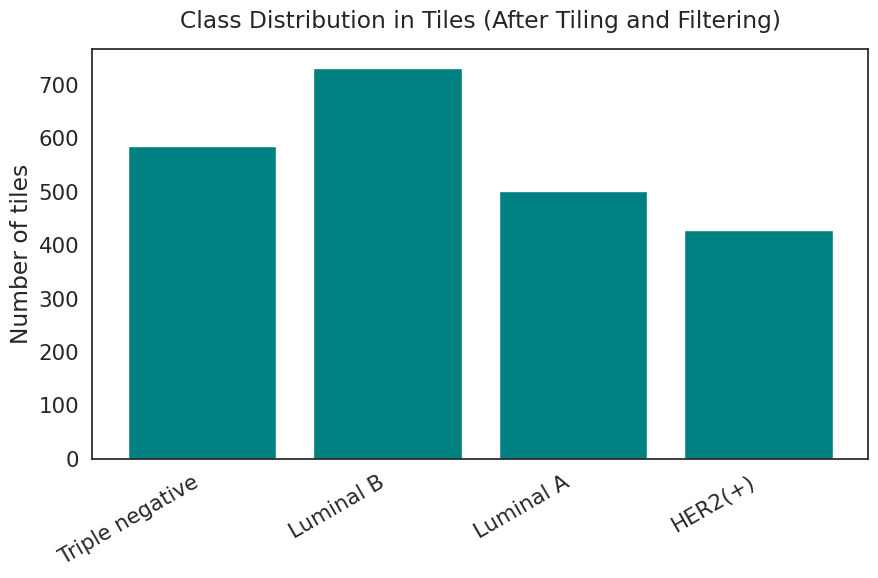

In [47]:
import matplotlib.pyplot as plt
from collections import Counter
import random
import math

# Assuming 'tiled_full_dataset' has been successfully created in the previous step
print(f"Total Number of Extracted Tiles: {len(tiled_full_dataset)}")


# ---------------------------------------------------------
# 📊 TILE'S LABELS DISTRIBUTION
# ---------------------------------------------------------

# Extract the encoded labels from the generated samples
labels_encoded = [label for _, label in tiled_full_dataset.samples]
label_counts = Counter(labels_encoded)

# Create a mapping from encoded index back to the string class name for readability
# (Assuming 'class_names' list is defined from the initial LabelEncoder step)
class_label_map = {i: name for i, name in enumerate(class_names)}

print("\n Tile's Label Distribution")
# Print using the human-readable class names
for cls_idx, count in label_counts.items():
    print(f"{class_label_map[cls_idx]}: {count} tiles")

# Bar plot
plt.figure(figsize=(9, 6))
# Use string labels for better visualization
plot_labels = [class_label_map[cls_idx] for cls_idx in label_counts.keys()]
plt.bar(plot_labels, label_counts.values(), color="teal")
plt.title("Class Distribution in Tiles (After Tiling and Filtering)", pad=15)
plt.ylabel("Number of tiles")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()




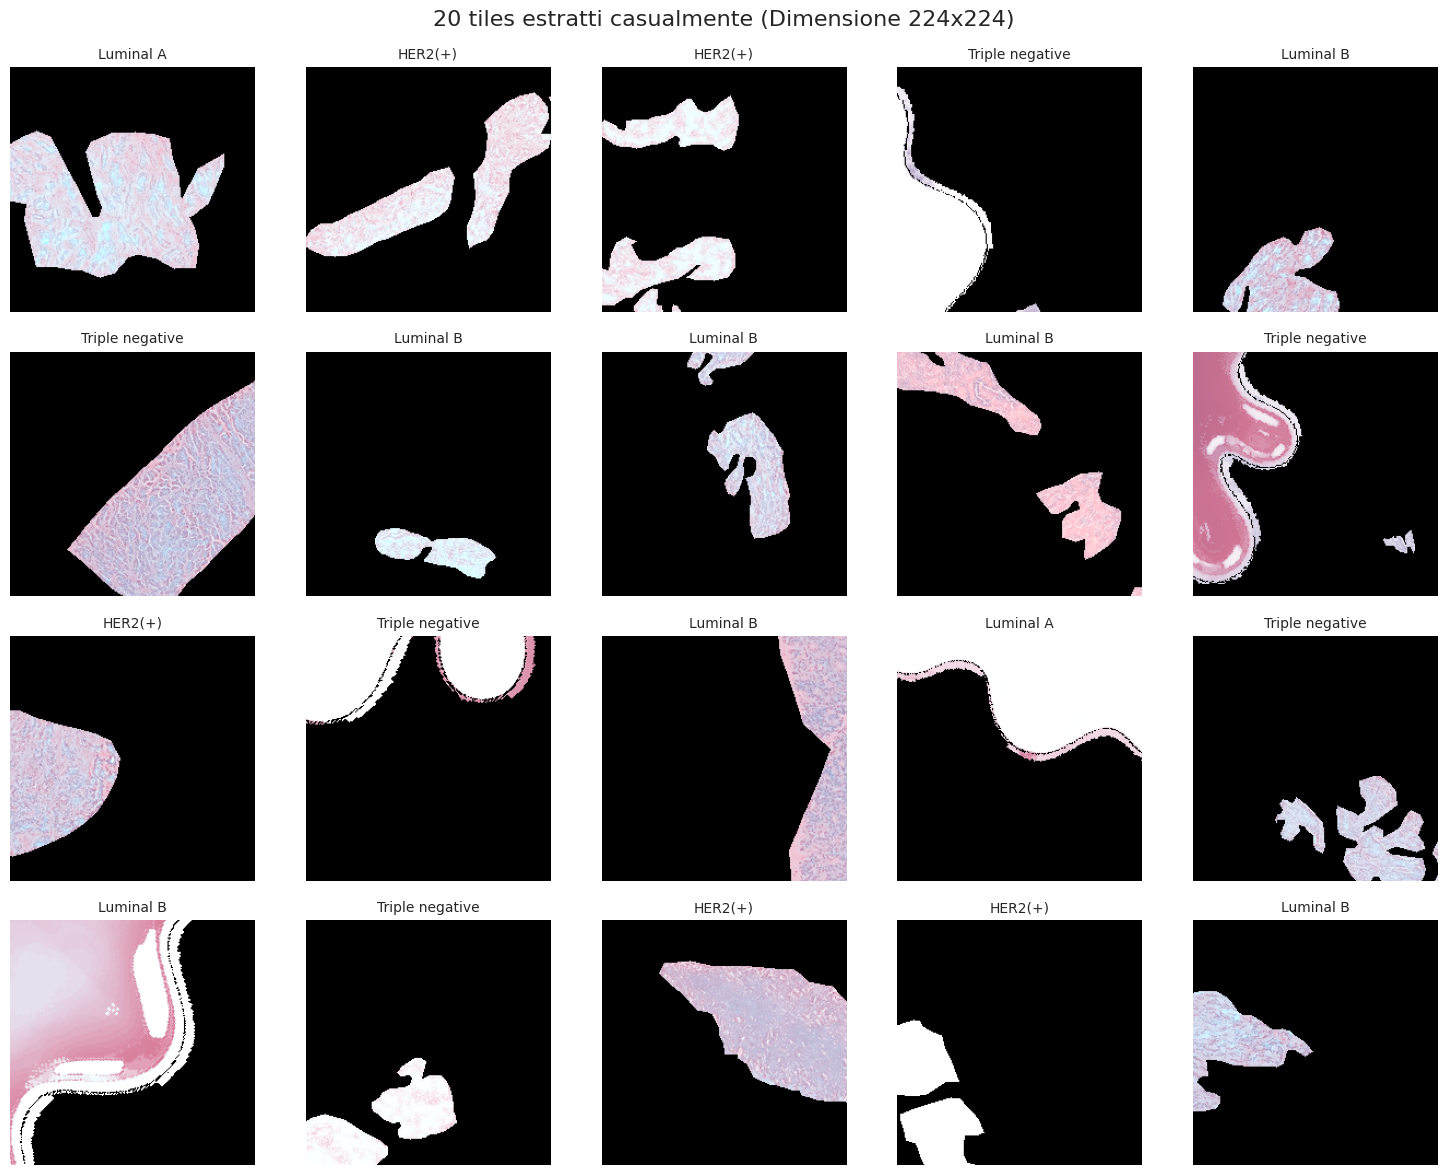

In [48]:
# ---------------------------------------------------------
# 🖼️ STAMPA DI ALCUNE IMMAGINI DEL DATASET (Corrected)
# ---------------------------------------------------------

def show_random_tiles(dataset, n=20):
    """Visualizza n tiles estratti casualmente dal dataset."""
    idxs = random.sample(range(len(dataset)), n)

    cols = int(math.ceil(math.sqrt(n)))
    rows = int(math.ceil(n / cols))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, idx in enumerate(idxs):
        # When you access the dataset here, you get the PIL image
        img_pil, label_encoded = dataset[idx]

        plt.subplot(rows, cols, i + 1)

        # Display the PIL Image directly.
        # Matplotlib handles PIL images without needing C H W -> H W C permutation.
        plt.imshow(img_pil)

        # Display the human-readable class name
        class_name = class_label_map.get(label_encoded, "Unknown")
        plt.title(class_name, fontsize=10)
        plt.axis("off")

    plt.suptitle(f"{n} tiles estratti casualmente (Dimensione {dataset.tile_size}x{dataset.tile_size})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Re-run the function
show_random_tiles(tiled_full_dataset, n=20)

##  **Data Splitting in Training and Validation Set**

In [49]:
##  **Data Splitting in Training and Validation Set (CORRETTO, NO LEAKAGE, STRATIFIED)**

from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. Slide-level dataframe (serve per stratificazione)
# ---------------------------------------------------------
slide_labels = labels_df[["sample_index", "label"]].drop_duplicates()

# ---------------------------------------------------------
# 2. Stratified train/val split per SLIDE
# ---------------------------------------------------------
train_ids, val_ids = train_test_split(
    slide_labels["sample_index"],
    test_size=0.15,
    random_state=SEED,
    stratify=slide_labels["label"]  # stratificazione per classe
)

print("\n--- Slide-level Split (NO LEAKAGE) ---")
print(f"Training slides:   {len(train_ids)}")
print(f"Validation slides: {len(val_ids)}")

# ---------------------------------------------------------
# 3. Filtra il labels_df per ottenere i due insiemi
# ---------------------------------------------------------
train_labels_df = labels_df[labels_df["sample_index"].isin(train_ids)]
val_labels_df   = labels_df[labels_df["sample_index"].isin(val_ids)]

print(f"Training slide entries:   {len(train_labels_df)}")
print(f"Validation slide entries: {len(val_labels_df)}")

# ---------------------------------------------------------
# 4. Definisci i Transform corretti (senza Macenko)
# ---------------------------------------------------------

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

print("\n✅ Transformation pipelines defined.")

# ---------------------------------------------------------
# 5. Crea i dataset TRAIN e VAL (Macenko è GIÀ applicato nel dataset)
# ---------------------------------------------------------

train_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=train_labels_df,
    le=le,
    tile_size=224,
    transform=train_transforms,
    min_mask_ratio=0.1,
)

val_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=val_labels_df,
    le=le,
    tile_size=224,
    transform=val_transforms,
    min_mask_ratio=0.1,
)

print(f"Total TRAIN tiles: {len(train_dataset)}")
print(f"Total VAL   tiles: {len(val_dataset)}")

# ---------------------------------------------------------
# 6. DataLoader Creation
# ---------------------------------------------------------

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print(f"\n✅ DataLoaders created with BATCH_SIZE={BATCH_SIZE}.")
print(f"Training batches:   {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")


--- Slide-level Split (NO LEAKAGE) ---
Training slides:   537
Validation slides: 95
Training slide entries:   537
Validation slide entries: 95

✅ Transformation pipelines defined.
[FALLBACK] Using fallback ratio 0.05 for img_0000.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0002.png
[FALLBACK] Using fallback ratio 0.05 for img_0004.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0006.png
[FALLBACK] Using fallback ratio 0.05 for img_0007.png
[FALLBACK] Using fallback ratio 0.05 for img_0010.png
[FALLBACK] Using fallback ratio 0.05 for img_0019.png
[FALLBACK] Using fallback ratio 0.05 for img_0029.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0030.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0033.png
[FALLBACK] Using fallback ratio 0.05 for img_0035.png
[FALLBACK] Using fallback ratio 0.025 for img_0041.png
[FALLBACK] Using fallback ratio 0.025 for img_0045.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for

##  🧮 **Network Parameters**

##  🧠 **Training Functions**

In [103]:
from sklearn.metrics import accuracy_score, f1_score # Ensure f1_score is imported

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        # Automatic Mixed Precision (AMP) block for efficient CUDA utilization
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        # Scale the loss, backpropagate, and update
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc

In [104]:
def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch, calculating loss, accuracy, and F1-Score."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # AMP block
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(y_true, y_pred)

    # Competition Metric: Calculate the Macro F1-Score
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_accuracy, epoch_f1

In [105]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=PATIENCE, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """
    Train the neural network model.
    Evaluation Metric is set to 'val_f1' by default for the competition.
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': [] # Added F1-Score tracking
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        # --- Training Step ---
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        # --- Validation Step ---
        # Capture the new F1-Score return value
        val_loss, val_acc, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # --- Update History ---
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)
        training_history['val_f1'].append(val_f1) # Record F1-Score

        # --- TensorBoard Logging ---
        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)
            writer.add_scalar('F1-Score/Validation', val_f1, epoch) # Log F1-Score

        # --- Console Output ---
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                      f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        # --- Early Stopping Logic ---
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                # Save the model state dict
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs (no improvement in {evaluation_metric} for {patience} epochs).")
                    break

    # --- Final Actions ---
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        # Save the final model if no early stopping was used
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

## 🛠️ **Transfer Learning EfficientNet**

In [85]:
# 🔧 Training parameters for EfficientNet
EPOCHS = 120           # 100–150 ok, con early stopping
PATIENCE = 15          # early stopping più “aggressivo”

# Learning rate
LEARNING_RATE = 3e-4   # transfer learning (backbone congelato)
FT_LEARNING_RATE = 1e-4  # fine-tuning (backbone parzialmente sbloccato)

# Regularization
DROPOUT_RATE = 0.25    # leggermente più basso di 0.28, meglio per EfficientNet

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate (TL):", LEARNING_RATE)
print("Learning Rate (FT):", FT_LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)

Epochs: 120
Batch Size: 32
Learning Rate (TL): 0.0003
Learning Rate (FT): 0.0001
Dropout Rate: 0.25
Patience: 15


In [86]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=PATIENCE, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name="",
        scheduler=None):
    """
    Train the neural network model.
    - evaluation_metric: default 'val_f1' (competition metric)
    - mode: 'max' if higher is better (F1, acc), 'min' for loss
    - scheduler: optional LR scheduler (e.g., CosineAnnealingLR)
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': []  # F1-Score tracking
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        # --- Training Step ---
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        # --- Validation Step ---
        val_loss, val_acc, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # --- Update History ---
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)
        training_history['val_f1'].append(val_f1)

        # --- LR Scheduler step (se presente) ---
        if scheduler is not None:
            scheduler.step(val_loss)


        # --- TensorBoard Logging ---
        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)
            writer.add_scalar('F1-Score/Validation', val_f1, epoch)
            # log anche il LR
            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar('LR', current_lr, epoch)

        # --- Console Output ---
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"LR={current_lr:.2e} | "
                      f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                      f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        # --- Early Stopping Logic ---
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs "
                          f"(no improvement in {evaluation_metric} for {patience} epochs).")
                    break

    # --- Final Actions ---
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + '_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history


In [87]:
import torchvision
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

In [88]:
class EfficientNetB2TransferLearning(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.4, freeze_backbone=True):
        super().__init__()

        self.backbone = efficientnet_b2(
            weights=EfficientNet_B2_Weights.IMAGENET1K_V1
        )

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        in_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


In [89]:
MODEL_BACKBONE = "efficientnet_b2"

tl_model = EfficientNetB2TransferLearning(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=True
).to(device)


In [90]:
experiment_name = "tl_efficientnet_b2_frozen"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

# Optimizer RMSProp (consigliato per EfficientNet)
optimizer = torch.optim.RMSprop(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE,      # 3e-4
    alpha=0.9,
    momentum=0.9,
    weight_decay=1e-5
)

# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)



scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\nStarting training for experiment: {experiment_name}")

tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1',
    scheduler=scheduler   # ⬅️ NUOVO
)


Starting training for experiment: tl_efficientnet_b2_frozen
Training 120 epochs...
Epoch   1/120 | LR=3.00e-04 | Train: Loss=1.4144, Acc=0.3150 | Val: Loss=1.4501, Acc=0.2459, F1=0.2388
Epoch   5/120 | LR=3.00e-04 | Train: Loss=1.4029, Acc=0.3502 | Val: Loss=1.4103, Acc=0.3432, F1=0.3276
Epoch  10/120 | LR=2.70e-05 | Train: Loss=1.3379, Acc=0.3763 | Val: Loss=1.4214, Acc=0.3189, F1=0.2963
Epoch  15/120 | LR=2.70e-05 | Train: Loss=1.3275, Acc=0.3859 | Val: Loss=1.4188, Acc=0.3378, F1=0.3095
Epoch  20/120 | LR=2.70e-05 | Train: Loss=1.3058, Acc=0.4174 | Val: Loss=1.4074, Acc=0.3649, F1=0.3366
Epoch  25/120 | LR=8.10e-06 | Train: Loss=1.3067, Acc=0.4126 | Val: Loss=1.4037, Acc=0.3459, F1=0.3195
Epoch  30/120 | LR=2.43e-06 | Train: Loss=1.3011, Acc=0.4019 | Val: Loss=1.4077, Acc=0.3432, F1=0.3184
Epoch  35/120 | LR=1.00e-06 | Train: Loss=1.3002, Acc=0.4195 | Val: Loss=1.4091, Acc=0.3324, F1=0.3061
Epoch  40/120 | LR=1.00e-06 | Train: Loss=1.2982, Acc=0.4131 | Val: Loss=1.4039, Acc=0.3541,

In [102]:
# --- CREATE MODEL FOR FINE-TUNING (UNFROZEN) ---

ft_model = EfficientNetB2TransferLearning(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=False
).to(device)

# 1. Load best weights from transfer learning stage
ft_model.load_state_dict(torch.load("models/tl_efficientnet_b2_frozen_model.pt"))

print("✅ Loaded weights from transfer learning stage.")

# 2. Freeze ALL backbone
for name, param in ft_model.backbone.named_parameters():
    param.requires_grad = False

# 3. Unfreeze last 4 blocks
blocks_to_unfreeze = ["5", "6", "7", "8"]

for name, param in ft_model.backbone.features.named_parameters():
    if any(name.startswith(b) for b in blocks_to_unfreeze):
        param.requires_grad = True

experiment_name = "fine_tuning_efficientnet_b2"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

optimizer = torch.optim.RMSprop(
    filter(lambda p: p.requires_grad, ft_model.parameters()),
    lr=FT_LEARNING_RATE,
    alpha=0.9,
    momentum=0.9,
    weight_decay=1e-5
)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1',
    scheduler=scheduler
)

✅ Loaded weights from transfer learning stage.
Training 120 epochs...
Epoch   1/120 | LR=1.00e-04 | Train: Loss=1.4243, Acc=0.3230 | Val: Loss=1.4417, Acc=0.3405, F1=0.2641
Epoch   5/120 | LR=3.00e-05 | Train: Loss=1.3357, Acc=0.3715 | Val: Loss=1.4896, Acc=0.3676, F1=0.3214
Epoch  10/120 | LR=9.00e-06 | Train: Loss=1.1775, Acc=0.4963 | Val: Loss=1.5669, Acc=0.3486, F1=0.3232
Epoch  15/120 | LR=2.70e-06 | Train: Loss=1.0626, Acc=0.5928 | Val: Loss=1.6752, Acc=0.3622, F1=0.3344
Epoch  20/120 | LR=1.00e-06 | Train: Loss=1.0588, Acc=0.5773 | Val: Loss=1.6707, Acc=0.3541, F1=0.3304
Epoch  25/120 | LR=1.00e-06 | Train: Loss=1.0463, Acc=0.6082 | Val: Loss=1.6601, Acc=0.3622, F1=0.3391
Epoch  30/120 | LR=1.00e-06 | Train: Loss=1.0315, Acc=0.6162 | Val: Loss=1.6798, Acc=0.3730, F1=0.3485
Epoch  35/120 | LR=1.00e-06 | Train: Loss=1.0216, Acc=0.6146 | Val: Loss=1.7027, Acc=0.3622, F1=0.3399
Epoch  40/120 | LR=1.00e-06 | Train: Loss=1.0213, Acc=0.6146 | Val: Loss=1.6942, Acc=0.3730, F1=0.3470
Epo

## **Inference Fine Tuning**

In [134]:
def fallback_extract_test_tiles(img, mask, tile_size, stride, min_mask_ratio):
    """
    Progressively relax min_mask_ratio to guarantee at least one tile.
    """
    for ratio in [min_mask_ratio * 0.75,
                  min_mask_ratio * 0.5,
                  min_mask_ratio * 0.25,
                  min_mask_ratio * 0.125,
                  0.02]:

        tiles = extract_test_masked_tiles(
            img, mask,
            tile_size=tile_size,
            stride=stride,
            min_mask_ratio=ratio
        )

        if tiles:
            # pick tile with max tumor mask coverage
            best_tile, best_mask = max(
                  tiles,
                  key=lambda t: (t[1] > 0).mean()    # t[1] is mask tile
              )
            return [(best_tile, best_mask)], ratio

    # no tile found even at minimum ratio
    return [], None


In [135]:
def extract_test_masked_tiles(img, mask, tile_size=224, stride=112, min_mask_ratio=0.02):
    """
    Divides the image into tiles, keeps those with tumor tissue (via mask).
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2] # Use image shape for dimensions
    tiles = []

    for y in range(0, H - tile_size + 1, int(stride)):
        for x in range(0, W - tile_size + 1, int(stride)):

            tile_img  = img_arr[y:y+tile_size, x:x+tile_size]
            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]
            #tile_img = tile_img * (tile_mask[..., None] > 0)

            # 1️⃣ Tile without tumor tissue (mask not active) → discarded
            if not mask_active(tile_mask, min_ratio=min_mask_ratio):
                continue

            tile = Image.fromarray(tile_img)

            # 3️⃣ Clean tumor tile → add to the list
            tiles.append((tile, tile_mask))

    return tiles

In [136]:

from torch.utils.data import Dataset

class HistologyMaskedTilesTest(Dataset):
    """
    Test dataset: generates tiles from WSI by using:
    - extract_test_masked_tiles (test version with falback)
    - Macenko normalization
    """
    def __init__(self, img_dir, tile_size=224, min_mask_ratio=0.1, transform=None):
        self.img_dir = img_dir
        self.tile_size = tile_size
        self.min_mask_ratio = min_mask_ratio
        self.transform = transform
        self.macenko = MacenkoTransform()

        # file list img_XXXX.png
        self.sample_names = sorted([
            f for f in os.listdir(img_dir) if f.startswith("img_")
        ])

        self.tiles = self._generate_tiles()


    def _generate_tiles(self):
        all_tiles = []

        for img_name in self.sample_names:
            img_path  = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            tiles = extract_test_masked_tiles(
                img, mask,
                tile_size=self.tile_size,
                stride=int(self.tile_size * 0.8),
                min_mask_ratio=self.min_mask_ratio
            )

            if not tiles:
                # Use fallback to guarantee at least one tile
                fallback_tiles, used_ratio = fallback_extract_test_tiles(img, mask, self.tile_size, stride=int(self.tile_size * 0.8), min_mask_ratio=self.min_mask_ratio)
                if fallback_tiles:
                    print(f"[FALLBACK] Using fallback ratio {used_ratio} for {img_name}")
                    tiles = fallback_tiles
                else:
                    print(f"[ERROR] No tile possible for {img_name}, skipping")
                    continue

            # --- Apply Macenko ---
            for tile_pil, tile_mask in tiles:    # ignore mask here
              t_norm = self.macenko(tile_pil)
              t_arr = np.array(t_norm)
              t_arr = t_arr * (tile_mask[..., None] > 0)
              t_norm = Image.fromarray(t_arr)
              all_tiles.append((t_norm, img_name))

        print(f"[TEST] Total tiles generated (Macenko-normalized): {len(all_tiles)}")
        return all_tiles


    def __getitem__(self, idx):
        tile_pil, sample_name = self.tiles[idx]

        if self.transform:
            tile_tensor = self.transform(tile_pil)
        else:
            tile_tensor = transforms.ToTensor()(tile_pil)

        return tile_tensor, sample_name


    def __len__(self):
        return len(self.tiles)

In [137]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [138]:
test_dataset = HistologyMaskedTilesTest(
    img_dir=test_img_dir,
    tile_size=224,
    min_mask_ratio=0.1,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0000.png
[FALLBACK] Using fallback ratio 0.05 for img_0001.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0005.png
[FALLBACK] Using fallback ratio 0.025 for img_0013.png
[FALLBACK] Using fallback ratio 0.025 for img_0017.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0021.png
[FALLBACK] Using fallback ratio 0.05 for img_0023.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0027.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0030.png
[FALLBACK] Using fallback ratio 0.0125 for img_0034.png
[FALLBACK] Using fallback ratio 0.025 for img_0039.png
[FALLBACK] Using fallback ratio 0.05 for img_0041.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0044.png
[FALLBACK] Using fallback ratio 0.05 for img_0045.png
[FALLBACK] Using fallback ratio 0.025 for img_0050.png
[FALLBACK] Using fallback ratio 0.07500000000000001 for img_0057.png
[FALLBACK] Using fallback

In [139]:
print("Unique slide names in loader:", len(set([n for _, batch_names in test_loader for n in batch_names])))
print(len(os.listdir(test_img_dir)))


Unique slide names in loader: 477
954


In [140]:
import torch.nn.functional as F
from collections import defaultdict

def infer(model, loader, device):
    model.eval()

    # dictionary: sample_name → lista logits
    slide_logits = defaultdict(list)

    with torch.no_grad():
        for images, names in loader:
            images = images.to(device)
            logits = model(images)  # shape (batch, num_classes)

            for logit, name in zip(logits, names):
                slide_logits[name].append(logit.cpu())

    # final predictions
    predictions = {}
    for slide, logit_list in slide_logits.items():
        mean_logit = torch.stack(logit_list).mean(dim=0)
        pred = mean_logit.argmax().item()
        predictions[slide] = pred

    return predictions

In [141]:
preds = infer(ft_model, test_loader, device)

# 4. Convert numeric predictions to text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}
preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# 5. Build final dataframe
df = pd.DataFrame({
    "sample_index": list(preds_text.keys()),
    "label": list(preds_text.values())
})


df.to_csv("224_bigger_mlp_head.csv", index=False)
print("Saved 224_bigger_mlp_head.csv")

from google.colab import files
files.download("224_bigger_mlp_head.csv")


Saved 224_bigger_mlp_head.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [142]:
# Estrai gli indici numerici dalla forma "img_XXXX.png"
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(476))

missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])  # Stampa solo le prime 50

Numero label mancanti: 0
Label mancanti: []
